In [1]:
import sys 
sys.path.insert(0,'../')

%matplotlib inline
from scripts.Deblender import Deblend
from scripts.utils import listdir_fullpath

import numpy as np
import os

import matplotlib.pyplot as plt

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

2022-04-08 23:10:18.496279: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-04-08 23:10:18.496328: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 100
max_number = 60
batch_size = 1
max_shift = 44
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("Rubin")
seed=3

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, maxshift=max_shift, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [3]:
def crop_image(image, pos, cutout_size):
    """
    crops a portion of the image.
    
    Parameters
    ----------
    image:
    
    pos:
    
    cutout_size: float
        cutout size in arcminutes
    
    Returns
    -------
    cropped image
    """
    
    cutout_pixel_size = int(cutout_size * 5)
    
    x_crop_start = int(pos[0] - (cutout_pixel_size-1)/2)
    x_crop_end = int(pos[0] + (cutout_pixel_size-1)/2)
    
    y_crop_start = int(pos[1] - (cutout_pixel_size-1)/2)
    y_crop_end = int(pos[1] + (cutout_pixel_size-1)/2)
    
    #print(np.shape(image))
    #print(pos)
    #print(x_crop_start)
    #print(x_crop_end+1)
    cropped_image = image[2, x_crop_start:x_crop_end+1, y_crop_start:y_crop_end+1]
    
    #print(np.shape(crop_image))
    return cropped_image.copy()


In [4]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

(6, 500, 500)

input_image


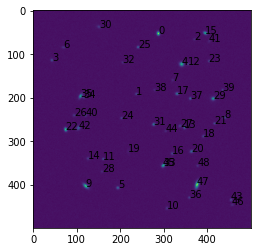

In [5]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

input_image


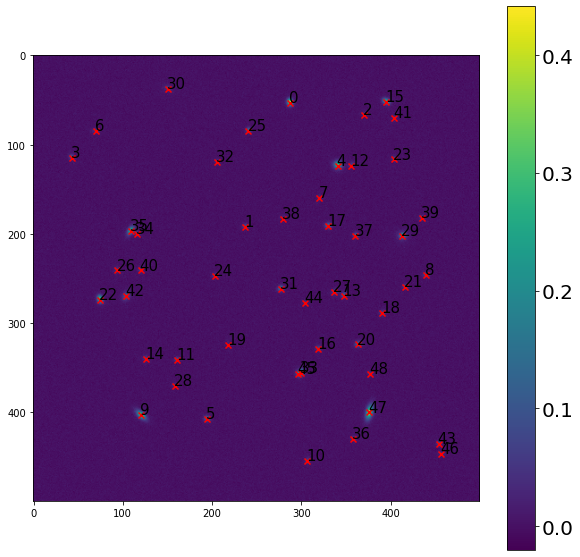

In [6]:
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][0, 2]/80000)
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
    plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), fontsize=15)
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)

In [7]:
tf.get_logger().setLevel('ERROR')

detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['y_peak'][i], blend['blend_list'][0]['x_peak'][i]])

deb = Deblend(blend['blend_images'][0]/80000, 
              detected_positions, 
              lr=.04, 
              latent_dim=10, 
              num_components=len(blend['blend_list'][0]), 
              use_likelihood=True, 
              max_iter=100)

2022-04-08 23:10:48.095144: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-04-08 23:10:48.095219: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 23:10:48.095258: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-04-08 23:10:48.095623: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 2

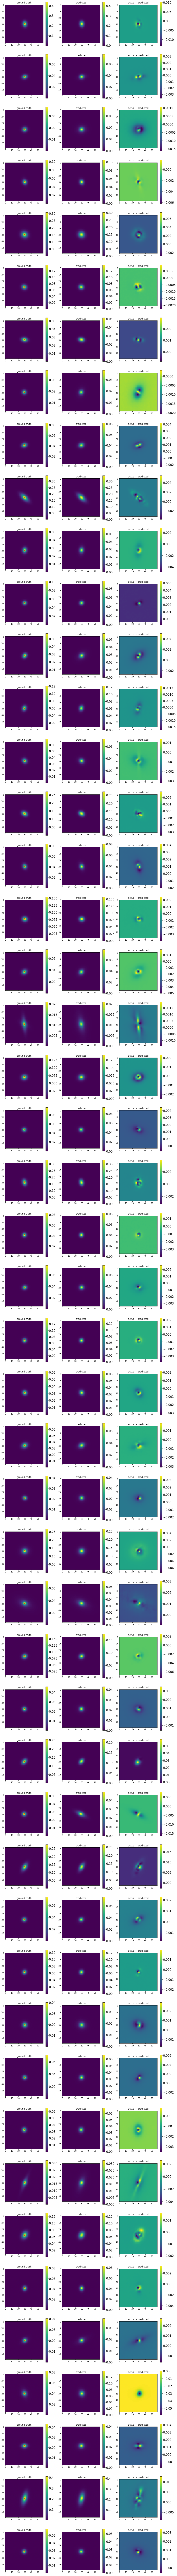

In [8]:
 fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 11.8))
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("ground truth")
    ax[i, 0].scatter(29, 29, c="r", marker="x")

    im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("predicted")
    
    im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 11.8) - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("actual - predicted")
    
plt.show()

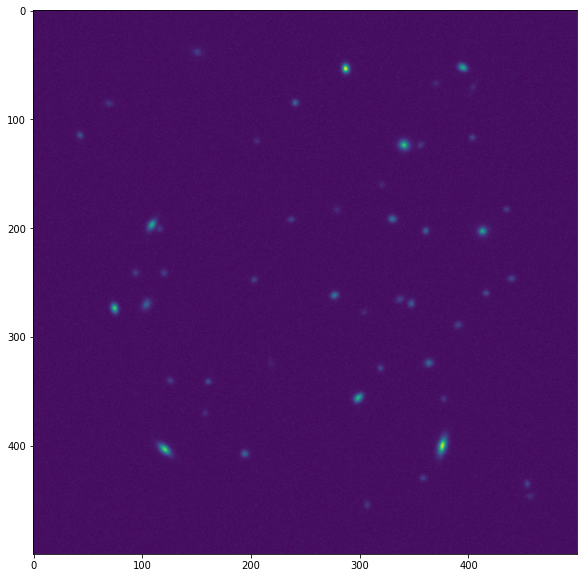

In [9]:
fig = plt.figure(figsize=(10,10))
plt.imshow(blend['blend_images'][0][1])

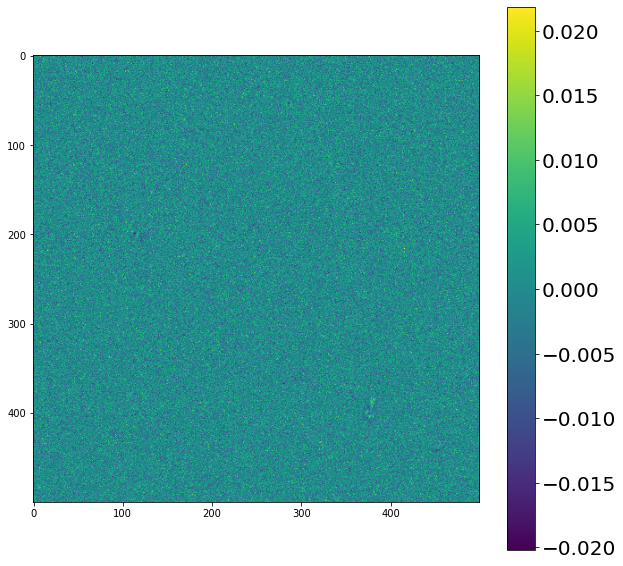

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(blend['blend_images'][0]/80000, use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 2])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
#for i in range(len(blend['blend_list'][0])):
    #plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

tf.Tensor(
[764628.2  768044.1  764801.8  759967.3  759120.25 757815.75 756750.5
 756025.9  756510.3  755635.56 755384.25 755171.8  754794.8  754798.06
 754711.9  754704.7  754626.7  754492.1  754471.5  754497.6  754342.8
 753923.25 753807.75 753810.44 753751.75 753815.9  753695.44 753649.75
 753616.06 753603.06 753425.6  753201.   752927.6  752778.   752799.75
 752649.75 752661.9  752553.9  752642.75 752571.06 752608.6  752273.4
 752056.25 752054.9  752059.8  752119.06 752128.   751999.9  751963.7
 752081.1  751895.7  751694.1  751541.7  751585.25 751523.4  751596.25
 751478.44 751464.6  751524.5  751522.8  751414.56 751263.4  751094.4
 751060.6  750982.56 751047.9  750952.   750996.25 750947.06 751051.7
 750926.8  750837.25 750743.2  750716.4  750726.25 750759.8  750747.5
 750747.9  750717.94 750781.   750781.   750781.   750781.   750781.
 750781.   750781.   750781.   750781.   750781.   750781.   750781.
 750781.   750781.   750781.   750781.   750781.   750781.   750781.
 750781.

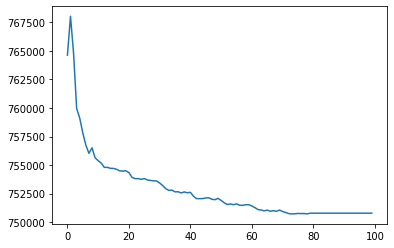

In [11]:
print(deb.results)
plt.plot(deb.results)

In [12]:
deb2 = Deblend(blend['blend_images'][0]/80000, 
              detected_positions, 
              lr=.1, 
              latent_dim=10, 
              num_components=len(blend['blend_list'][0]), 
              use_likelihood=True, 
              max_iter=100)



Using encoder for initial point

--- Starting gradient descent in the latent space ---
Number of iterations: 100
Learning rate: 0.1
Number of Galaxies: 49
Dimensions of latent space: 10
--- Gradient descent complete ---

Time taken for gradient descent: 38.92095112800598


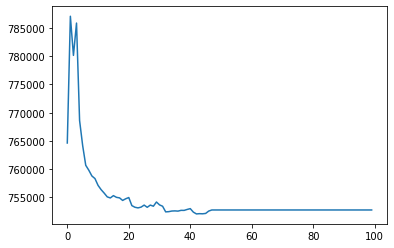

In [13]:
plt.plot(deb2.results)

In [14]:
deb3 = Deblend(blend['blend_images'][0]/80000, 
              detected_positions, 
              lr=.03, 
              latent_dim=10, 
              num_components=len(blend['blend_list'][0]), 
              use_likelihood=True, 
              max_iter=100)



Using encoder for initial point

--- Starting gradient descent in the latent space ---
Number of iterations: 100
Learning rate: 0.03
Number of Galaxies: 49
Dimensions of latent space: 10
--- Gradient descent complete ---

Time taken for gradient descent: 65.77742862701416


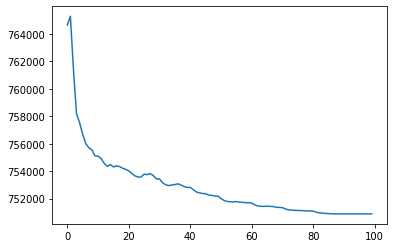

In [15]:
plt.plot(deb3.results)

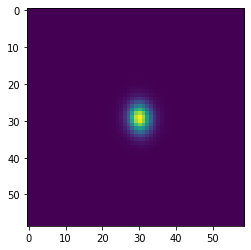

In [16]:
plt.imshow(deb.components[0][:, :, 2])

# Now compare to debvader output

In [17]:
from debvader.model import load_deblender
from debvader.deblender import deblend, DeblendField
from debvader.detection import detect_objects
from debvader.extraction import extract_cutouts
from debvader.normalize import LinearNormCosmos

In [18]:
# First, define the parameters of the neural network, for this version of debvader, they are as follow:
nb_of_bands = 6
input_shape = (59, 59, nb_of_bands)
latent_dim = 10
filters = [32,64,128,256]
kernels = [3,3,3,3]

# We will load the weights of the network trained on DC2 images
survey = "dc2"

In [19]:
# Load the network using the load_deblender function
net, encoder, decoder, z = load_deblender(loading_path='/pbs/throng/lsst/users/bbiswas/train_debvader/cosmos/updated_cosmos10dim_small_sig/deblender/val_loss', 
                                          input_shape=input_shape,
                                          latent_dim=latent_dim, 
                                          filters=filters, 
                                          kernels=kernels, 
                                          return_encoder_decoder_z=True)

in cropping
weights loaded from: /pbs/throng/lsst/users/bbiswas/train_debvader/cosmos/updated_cosmos10dim_small_sig/deblender/val_loss


In [20]:
blended_image = np.transpose(blend['blend_images'][0], axes = (1,2,0)).copy()
detected_positions_to_center = list(np.array(detected_positions) - (stamp_size*5-1)/2)
Deblender = DeblendField(net, blended_image, normalizer=LinearNormCosmos())
res_deblending_btk = Deblender.deblend_field(detected_positions_to_center)

In [21]:
res_deblending_btk_meta = Deblender.get_deblending_meta_data()

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

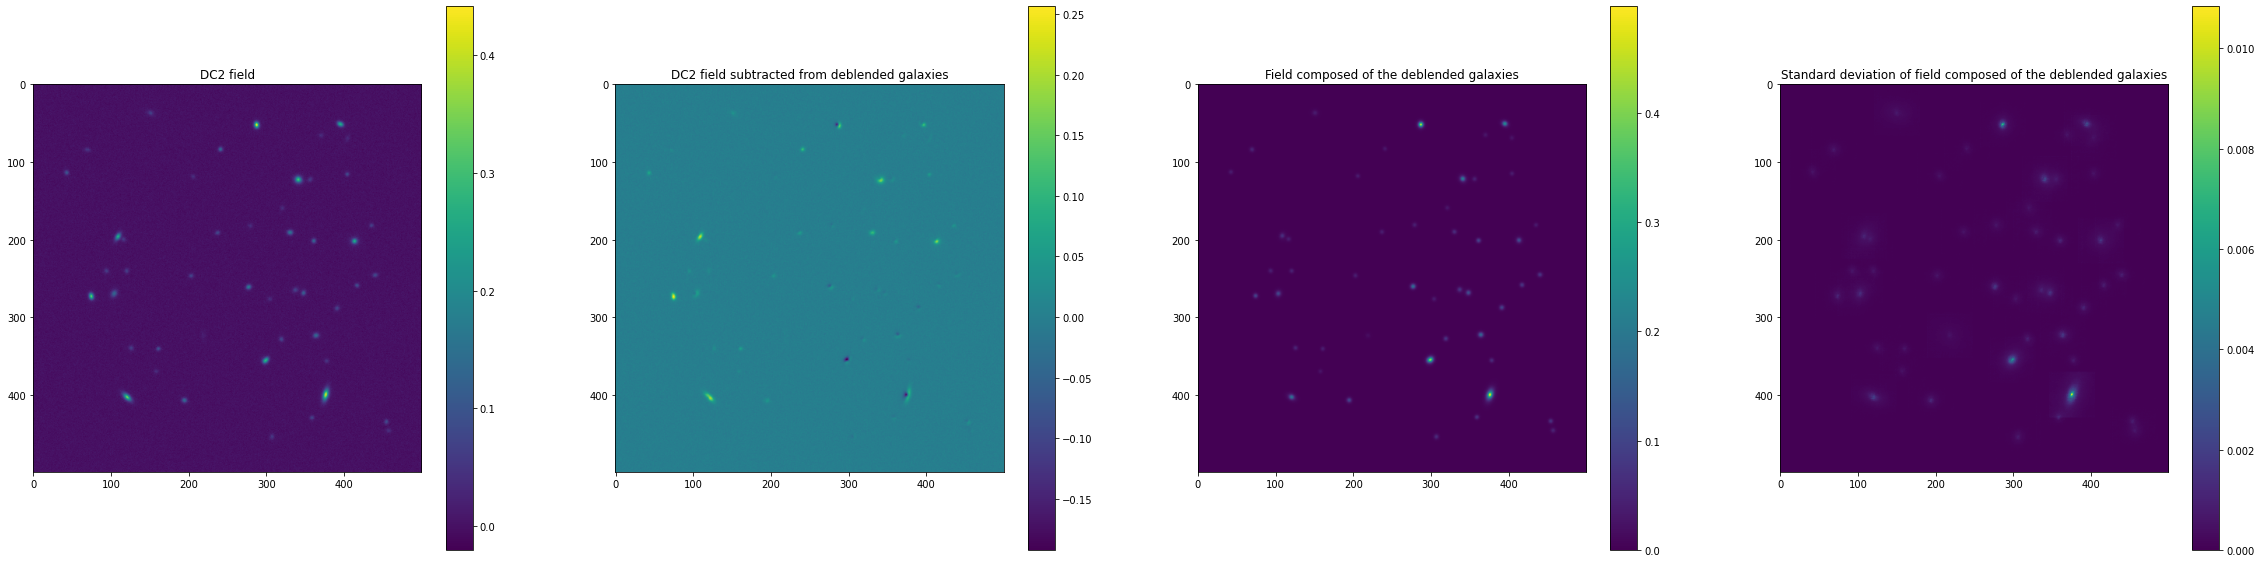

In [22]:
bands = 2

fig, axes = plt.subplots(1,4, figsize = (40,10))
im = axes[0].imshow(res_deblending_btk_meta['field_image'][:,:,bands]/80000)
fig.colorbar(im, ax=axes[0])
im = axes[1].imshow(res_deblending_btk_meta['deblended_image'][:,:,bands]/80000)
fig.colorbar(im, ax=axes[1])
im = axes[2].imshow(res_deblending_btk_meta['predicted_mean_field'][:,:,bands]/80000)
fig.colorbar(im, ax=axes[2])
im = axes[3].imshow(res_deblending_btk_meta['predicted_stddev_field'][:,:,bands]/80000)
fig.colorbar(im, ax=axes[3])

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')